In [1]:
from torchvision import transforms
from torch.utils.data import random_split
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torch import nn
import torch.nn.functional as F
import torch
from torch.optim import Adam

from torch import cuda

from torchinfo import summary

import matplotlib.pyplot as plt
import pandas as pd
from skimage import io
from tqdm import tqdm
import os

In [2]:
### Parameters
batch_size = 64
crop_size = 256
image_size = 102

save_t00 = True
load_t00 = False

save_t01 = True
load_t01 = False

torch.manual_seed(12)

if cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

### Hyperparams
learning_rate = 0.002
betas = (0.9, 0.999)

In [3]:
class GZ2Dataset(Dataset):
    def __init__(self, csv_file_maps: str, csv_file_data: str, root_dir: str, transform = None) -> None:
        """
        Initializes the dataset.

        Parameters:
            csv_file_maps (str): Name of *.csv file that contains the filename to id mapping for the images
            csv_file_data (str): Name of *.csv file that contains the labeled data for every id
            root_dir (str): Directory containing all the images
            transform (class from torchvision.transforms): Transform to be used on the image data
        """
        self.maps = pd.read_csv(csv_file_maps)
        self.data_loaded = pd.read_csv(csv_file_data)
        self.data = self.data_loaded[:-round(0.15*len(self.data_loaded))] # Reserve last 15% of elements for testing
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self) -> int:
        """
        Returns the size of the dataset as number of elements.

        Returns:
            int: Number of elements
        """
        return len(self.data)
    
    def __getitem__(self, index: int) -> tuple:
        """
        Returns an element from the dataset for a given index.

        Parameters:
            index (int): The index of the element to be returned

        Returns:
            tuple: Tuple in the form of (image_data: torch.Tensor, datapoint_1, datapoint_2, ...)

        """
        # Value of the "dr7objid" field for the current element
        dr7objid = self.data['dr7objid'][index]

        filename = str(self.maps[self.maps['objid'] == dr7objid]['asset_id'].item()) + '.jpg'
        image_path = os.path.join(self.root_dir, filename)
        image = io.imread(image_path) # Load image as numpy tensor with normalized color values

        # pandas Dataframe containing all the datapoints for the given dr7objid
        image_data = self.data.loc[self.data['dr7objid'] == dr7objid]

        # Select prediction (for t01) from maximum percentage of votes 
        predictions_t01 = [image_data.to_numpy()[0][13], image_data.to_numpy()[0][19], image_data.to_numpy()[0][25]]
        prediction_t01 = predictions_t01.index(max(predictions_t01))

        predictions_t02 = [image_data.to_numpy()[0][31], image_data.to_numpy()[0][37]]
        prediction_t02 = predictions_t02.index(max(predictions_t02))

        # Possible predictions:
        # 0:= smooth
        # 1:= features
        # 2:= star

        if self.transform:
            image = self.transform(image)

        output = tuple([image.to(device), torch.tensor(prediction_t01).to(device), torch.tensor(prediction_t02).to(device)])#, torch.tensor(predictions).to(device)])

        return output

In [4]:
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.RandomRotation(degrees=(0,180)), 
                                transforms.CenterCrop(crop_size), 
                                transforms.Resize(image_size)]) # Transforms to be used on the data

dataset = GZ2Dataset(csv_file_maps='gz2_filename_mapping.csv', 
                     csv_file_data='gz2_hart16_cleaned.csv', 
                     root_dir='images_gz2/images/', 
                     transform=transform)

# Split dataset into training and testing data using 80% of the dataset for training and 20% for validation 
trainset, testset, rest = random_split(dataset, [round(0.05*len(dataset)), round(0.002*len(dataset)), round(0.948*len(dataset))])

In [5]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)

In [6]:
class CNN_T00(nn.Module):
    def __init__(self, save_file: str):
        super(CNN_T00, self).__init__()
        self.save_file = save_file
        
        self.net = nn.Sequential(nn.Conv2d(3, 32, 3),
                                 nn.MaxPool2d((2,2)),
                                 nn.Dropout(0.1),

                                 nn.Conv2d(32, 64, 3),
                                 nn.MaxPool2d((2,2)),
                                 nn.Dropout(0.1),

                                 nn.Conv2d(64, 128, 3),
                                 nn.MaxPool2d((2,2)),
                                 nn.Dropout(0.2),

                                 nn.Conv2d(128, 256, 3),
                                 nn.MaxPool2d((2,2)),
                                 nn.Dropout(0.3),

                                 

                                 nn.Flatten(),

                                 nn.Linear(256 * 4 * 4, 128),
                                 nn.ReLU(),
                                 nn.Dropout(0.4),

                                 nn.Linear(128, 32),
                                 nn.LeakyReLU(),
                                 nn.Dropout(0.5),
                                 
                                 nn.Linear(32, 3))
    
    def forward(self, x):
        x = self.net(x)
        return x

In [7]:
class CNN_T01(nn.Module):
    def __init__(self, save_file: str):
        super(CNN_T01, self).__init__()
        self.save_file = save_file
        
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3) 
        self.conv3 = nn.Conv2d(64, 128, 2)

        self.lin1 = nn.Linear(128*11*11, 128)
        self.lin2 = nn.Linear(128, 32)
        self.out = nn.Linear(32, 3)
    
    def forward(self, x):
        x = F.dropout(F.max_pool2d(self.conv1(x), (2,2)), 0.1)
        x = F.dropout(F.max_pool2d(self.conv2(x), (2,2)), 0.2)
        x = F.dropout(F.max_pool2d(self.conv3(x), (2,2)), 0.3)
        #print(x.shape)

        x = x.flatten(start_dim=1)

        #x = self.drop1(x)

        x = F.dropout(F.relu(self.lin1(x)), 0.5)
        x = F.dropout(F.leaky_relu(self.lin2(x)), 0.5)
        x = self.out(x)
        return x

In [8]:
net_t00 = CNN_T00('net_t00.state').to(device)
net_t01 = CNN_T01('net_t01.state').to(device)

optim_t00 = Adam(net_t00.parameters(), lr=learning_rate, betas=betas)
optim_t01 = Adam(net_t01.parameters(), lr=learning_rate, betas=betas)
criterion = nn.CrossEntropyLoss().to(device)

In [9]:
print(summary(net_t00, (batch_size, 3, image_size, image_size)))

Layer (type:depth-idx)                   Output Shape              Param #
CNN_T00                                  [64, 3]                   --
├─Sequential: 1-1                        [64, 3]                   --
│    └─Conv2d: 2-1                       [64, 32, 100, 100]        896
│    └─MaxPool2d: 2-2                    [64, 32, 50, 50]          --
│    └─Dropout: 2-3                      [64, 32, 50, 50]          --
│    └─Conv2d: 2-4                       [64, 64, 48, 48]          18,496
│    └─MaxPool2d: 2-5                    [64, 64, 24, 24]          --
│    └─Dropout: 2-6                      [64, 64, 24, 24]          --
│    └─Conv2d: 2-7                       [64, 128, 22, 22]         73,856
│    └─MaxPool2d: 2-8                    [64, 128, 11, 11]         --
│    └─Dropout: 2-9                      [64, 128, 11, 11]         --
│    └─Conv2d: 2-10                      [64, 256, 9, 9]           295,168
│    └─MaxPool2d: 2-11                   [64, 256, 4, 4]           --
│

In [10]:
import net

epochs = 3

if not load_t00:
    #net.trainloop(trainloader, optim_t00, criterion, net_t00, epochs=epochs)
    net.train_validation_loop(trainloader, testloader, optim_t00, criterion, net_t00, epochs)

    if save_t00:
        net.save_net(net_t00)
else:
    net_t00 = net.load_net(net_t00, device=device)

net.validation_loop(testloader, criterion, net_t00)

> Validation on test data : 100%|██████████| 7/7 [00:05<00:00,  1.37it/s, acc=0.803, loss=0.414]


In [12]:
net.validation_loop(testloader, criterion, net_t00)

> Validation on test data : 100%|██████████| 7/7 [00:05<00:00,  1.31it/s, acc=0.784, loss=0.429]


In [11]:
epochs = 3

if not load_t01:
    net.trainloop(trainloader, optim_t01, criterion, net_t01, epochs=epochs)

    if save_t01:
        net.save_net(net_t01)
else:
    net_t01 = net.load_net(net_t01, device=device)

net.validation_loop(testloader, criterion, net_t01)

Epoch [2/3]:  53%|█████▎    | 85/160 [01:21<01:11,  1.05it/s, loss=0.535]


KeyboardInterrupt: 

43915
Guess: featured
Label: smooth


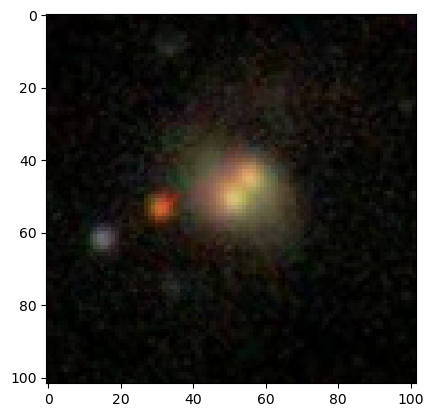

In [ ]:
entry = next(iter(testloader))
image = entry[0]
label = entry[1:]

print(len(testset))

prediction_t00 = net_t00(image.reshape(batch_size,3,image_size,image_size))
prediction_t01 = net_t01(image.reshape(batch_size,3,image_size,image_size))

plt.imshow(image[0].permute(1,2,0).cpu().numpy())

#print(prediction.topk(1,dim=1)[1][0])

print('Guess: ' + ['smooth', 'featured', 'star'][prediction_t00.topk(1,dim=1)[1][0].item()])
print('Label: ' + ['smooth', 'featured', 'star'][label[0][0].item()])
if label[0][0].item() == 1:#prediction_t00.topk(1,dim=1)[1][0].item() == 1:
    print('> edgeon? G: ' + ['yes', 'no'][prediction_t01.topk(1,dim=1)[1][0]] + ', L: ' + ['yes', 'no'][label[0][1].item()])
#print('Label percentage: ' + str(label_split[0].tolist()))